# Quantum Approximate Optimization Algorithm: Solving the MaxCut problem on a simple graph 
In this notebook we illustrate how to solve the MaxCut problem on a simple 4-nodes graph using the QAOA

## Contents  
1. [Overview](#Overview)  
    1.1 [QAOA](#Overview_QAOA)  
    1.2 [MaxCut on graphs](#Overview_maxcut) 
2. [Build the graph](#Graph)
3. [Hamiltonian of the problem](#Hamiltonian)
4. [Classical solution](#Classical_solution)
5. [QAOA method](#QAOA)  
    5.1 [Create the QAOA quantum circuit](#QAOA_qc)  
    5.2 [Perform the optimization](#QAOA_optimization)

<a id="Overview"></a>
## 1. Overview 

<a id="Overview_QAOA"></a>
### 1.1 QAOA
The Quantum Approximate Optimization Algorithm is a hybrid algorithm which works in the following way:  
The qubits are put in a balanced superposition state by applying an Hadamard gate on each of them. After that, we apply parameterized evolution operators, evolving the qubits under the cost hamiltonian and the mixer hamiltonian, alternately, $p$ times. At the end of the circuit we reconstruct the quantum state, compute the energy and update the parameters. We repeat it until we find the best parameters 

<a id="Overview_maxcut"></a>
### 1.2 MaxCut on graphs
Given a graph $G=(V,E)$ where $V$ is the set of vertices (or nodes) and $E$ is the set of edges, the MaxCut problem asks to split the nodes into two subsets (conventionally labeled $0$ and $1$) such that the number of edges connecting a node in the set $0$ and a node in the set $1$ is maximum.  
The problem is equivalent to find the bitstring which minimizes the following hamiltonian:  
$H=\sum_{(i,j)\in E}\frac{1}{2}(Z_iZ_j-1)$

<a id="Graph"></a>
## 2. Build the graph
First of all, let's construct the graph which we want to solve the MaxCut on. We'll create a 4-nodes graph with the Networkx package

In [1]:
import numpy as np
import networkx as nx

num_nodes = 4
w = np.array([[0., 1., 1., 0.],
              [1., 0., 1., 1.],
              [1., 1., 0., 1.],
              [0., 1., 1., 0.]])
G = nx.from_numpy_array(w)

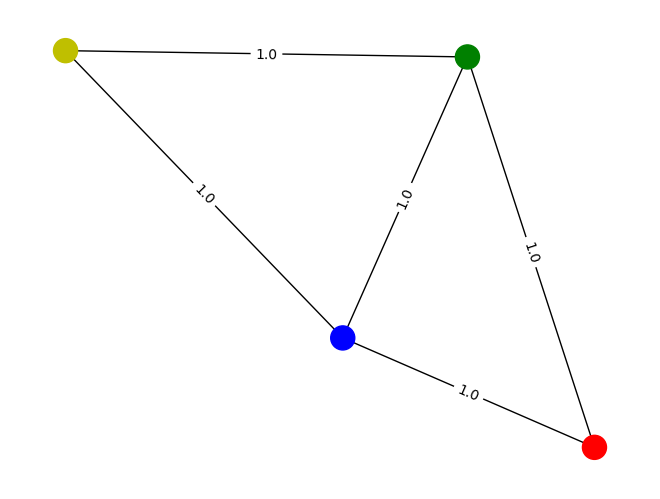

In [2]:
layout = nx.random_layout(G, seed=10)
colors = ['r', 'g', 'b', 'y']
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

Now, we create two functions:  
The former takes two integer numbers n and L, returning the binary representation of n as a bitstring of length L;  
The latter takes a bitstring x and the weight matrix w of the graph and computes the cut value for the bitstring x

In [3]:
def bitfield(n, L):
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]

In [4]:
def objective_value(x, w):
    X = np.outer(x, (1 - x)) #COMPUTE THE OUTER PRODUCT (RETURNING A MATRIX)
    w_01 = np.where(w != 0, 1, 0) 
    return np.sum(w_01 * X) 

<a id="Hamiltonian"></a>
## 3. Hamiltonian of the problem
Now let's create the Qiskit operator form of the MaxCut hamiltonian that we want to minimize

In [5]:
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator

def get_operator(weight_matrix):
    num_nodes = len(weight_matrix) ##IT IS THE NUMBER OF QUBITS WE WILL WORK WITH
    pauli_list = []
    coeffs = []
    shift=0
    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(0.5)
                shift -= 0.5
    h1=SparsePauliOp.from_operator(Operator(shift*np.identity(2**num_nodes)))
    h2=SparsePauliOp(pauli_list, coeffs=coeffs)

    return SparsePauliOp.sum([h1,h2])

qubit_op= get_operator(w)#LET'S DEFINE THE VARIABLE qubit_op WHICH CONTAINS OUR HAMILTONIAN OPERATOR

The next function computes, given a state vector, the bitstring which is most likely to come out in a measurement, which should be our solution bitstring  

In [6]:
from qiskit.primitives import Estimator

def sample_most_likely(state_vector):
    values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

<a id="Classical_solution"></a>
## 4. Classical solution
Before performing the QAOA, let's try to solve the MaxCut problem with a classical method, i.e. diagonalizing the cost hamiltonian

In [7]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit.quantum_info import Operator

npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(Operator(qubit_op))

x = sample_most_likely(result.eigenstate.data)
print(x)
print(f'Objective value computed by the NumPyMinimumEigensolver is {objective_value(x, w)}')

[0 1 1 0]
Objective value computed by the NumPyMinimumEigensolver is 4


<a id="QAOA"></a>
## 5. QAOA method

<a id="QAOA_qc"></a>
### 5.1 Create the QAOA quantum circuit
Let's now solve the problem with QAOA. First of all we need to create the parameterized quantum circuit which will be our ansatz

In [8]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector

def create_graph_edges(w): ##THIS FUNCTION CREATES A LIST CONTAINING THE EDGES OF THE GRAPH
    g=[]
    for i in range(len(w)):
        for j in range(i):
            if w[i,j]!=0:
                g.append((i,j))
    return g

def create_parameterized_circuit(w,p,g): #HERE WE CREATE THE PARAMETERIZED QUANTUM CIRCUIT BY HAND
    N=len(w)
    gamma=ParameterVector('gamma',p)
    beta=ParameterVector('beta',p)
    qr=QuantumRegister(N, 'q')
    qc=QuantumCircuit(qr)
    qc.h(qr[0:N])
    for i in range(p):
        for edge in g: 
            qc.cx(edge[0],edge[1])
            qc.rz(2*gamma[i],edge[1])
            qc.cx(edge[0],edge[1])
        qc.barrier()
        qc.rx(2*beta[i],qr[0:N])#mixer layer
        qc.barrier()
    return qc

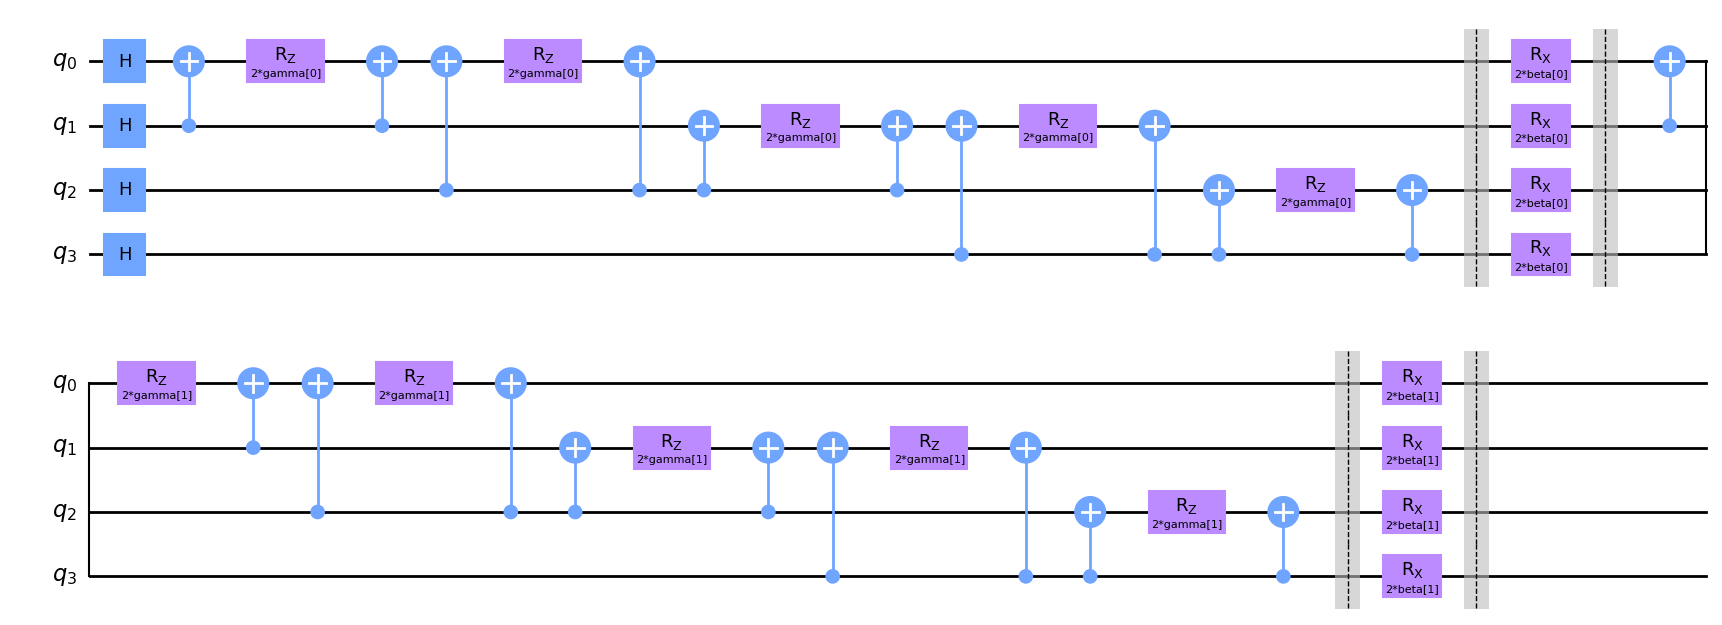

In [9]:
g=create_graph_edges(w)
p=2
qc=create_parameterized_circuit(w,p,g)
qc.draw('mpl')

<a id="QAOA_optimization"></a>
### 5.2 Perform the optimization
Let's perform the optimization and find the most likely solution bitstring. We'll perform the optimization with $p=1$, $p=2$, $p=3$ and check that, as the depth increases, the QAOA singles out the correct solution bitstring

In [10]:
from qiskit_algorithms import VQE
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize as opt
from functools import partial

optimizer=partial(opt,method='L-BFGS-B')
estimator=Estimator()
states=[]
for i in [1,2,3]:
    p=i
    qc=create_parameterized_circuit(w,p,g)
    start=np.full(2*p,0.2)
    sampling_vqe = VQE(estimator, qc, optimizer=optimizer, initial_point=start)
    result = sampling_vqe.compute_minimum_eigenvalue(qubit_op)
    qc=result.optimal_circuit.assign_parameters(result.optimal_point)
    state=Statevector(qc).data
    states.append(state)

In [11]:
import matplotlib.pyplot as plt

states=np.array(states)
mod_sq=states*np.conjugate(states)

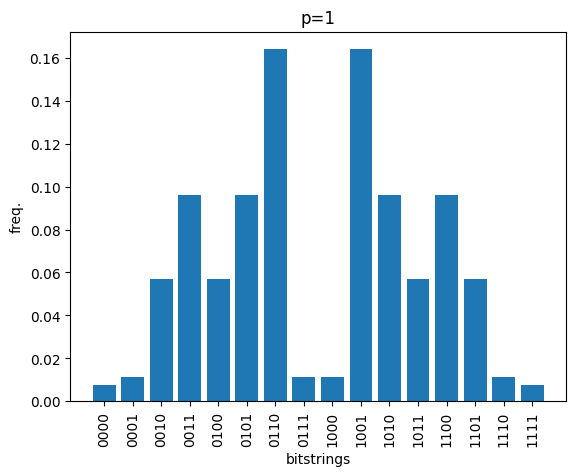

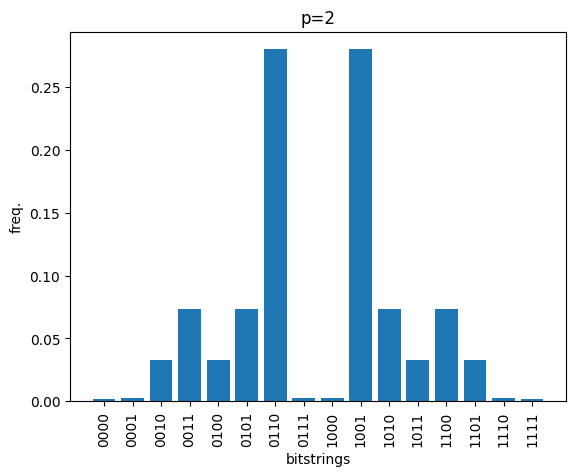

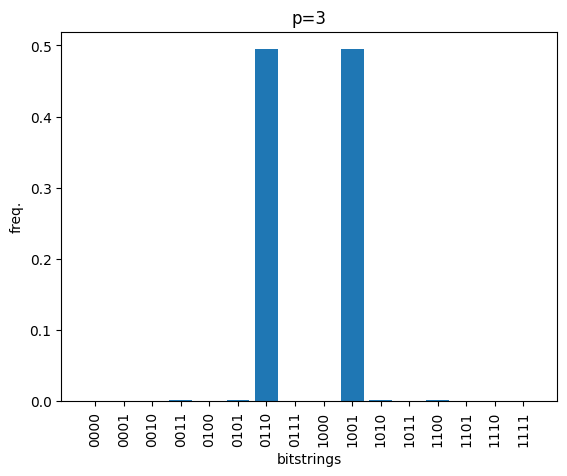

In [12]:
for i in [1,2,3]:
    plt.figure(i)
    xticks = range(0, 16)
    xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
    plt.title("p={}".format(i))
    plt.xlabel("bitstrings")
    plt.ylabel("freq.")
    plt.xticks(xticks, xtick_labels, rotation="vertical")
    plt.bar(xticks,mod_sq[i-1].real)